# CBOW(Continuous bag-of-words)
> 참고: 책 <<밑바닥부터 시작하는 딥러닝2>>, pp.132-141

In [1]:
CORPUS = 'You say goodbye and I say hello.'

말뭉치를 단어 ID로 변환한다.

In [2]:
import numpy as np

# 변환 함수
def preprocess(corpus):
    # 소문자 변환
    corpus = corpus.lower()
    
    # 마침표 앞에 공백 추가
    corpus = corpus.replace('.', ' .')
    
    # 공백 기준으로 단어 나누기
    words = corpus.split()
    
    word_to_id = {}
    id_to_word = {}
    now_id = 0
    for w in words:
        if w not in word_to_id:
            word_to_id[w] = now_id
            id_to_word[now_id] = w
            now_id += 1

    # 각 단어에 대한 id
    ids = np.array([word_to_id[w] for w in words])

    return ids, word_to_id, id_to_word

In [3]:
ids, word_to_id, id_to_word = preprocess(CORPUS)

In [4]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

맥락과 타겟을 만든다.

In [5]:
def create_target_contexts(ids, window_size=1):
    '''
    window_size: target의 좌우 몇 개의 단어를 고려할 것인가?
    '''

    # 타겟
    target = ids[window_size:-window_size]

    # 맥락
    contexts = []
    for i in range(window_size, len(ids) - window_size):
        contexts.append([ids[i - window_size], ids[i + window_size]])
    
    return np.array(target), np.array(contexts)


In [6]:
target, contexts = create_target_contexts(ids)

In [7]:
print(target)
print(contexts)

[1 2 3 4 1 5]
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


one-hot 벡터로 변환

In [8]:
# one-hot 벡터 변환 함수
def to_one_hot(words):
    oh_dict = {}
    len_words = len(words)

    for idx, w in enumerate(words):
        temp = [0] * len_words
        temp[idx] = 1
        oh_dict[w] = temp
    
    return oh_dict

In [9]:
one_hot = to_one_hot(list(id_to_word.keys()))
one_hot

{0: [1, 0, 0, 0, 0, 0, 0],
 1: [0, 1, 0, 0, 0, 0, 0],
 2: [0, 0, 1, 0, 0, 0, 0],
 3: [0, 0, 0, 1, 0, 0, 0],
 4: [0, 0, 0, 0, 1, 0, 0],
 5: [0, 0, 0, 0, 0, 1, 0],
 6: [0, 0, 0, 0, 0, 0, 1]}

In [10]:
target_oh = []
contexts_oh = []

for t in target:
    target_oh.append(one_hot[t])

for context in contexts:
    temp = []
    for c in context:
        temp.append(one_hot[c])
    contexts_oh.append(temp)

target_oh = np.array(target_oh)
contexts_oh = np.array(contexts_oh)

print(target_oh)
print(contexts_oh)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


CBOW 모델 구현

In [11]:
import sys
sys.path.append('../')

from common.layers import MatMul, SoftmaxWithLoss

In [12]:
class CBOW:
    def __init__(self, vocab_size, hidden_size):
        '''
        vocab_size = 어휘 수
        hidden_size = 은닉층 뉴런 수
        '''
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        # MatMul 계층은 맥락에 사용하는 단어 수만큼 만들어 준다.
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 단어 분산 표현 저장
        self.word_vecs = W_in
    
    
    def forward(self, contexts, target):
        '''
        맥락과 타겟을 받아 손실을 반환한다.
        contexts: 0번째 차원 -> 미니배치 수, 1번째 차원 -> 맥락의 윈도우 크기, 2번째 차원 -> one-hot 벡터
        '''

        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None
        

학습 코드 구현

In [13]:
from common.trainer import Trainer
from common.optimizer import Adam

In [14]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000
vocab_size = len(word_to_id)

In [15]:
model = CBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

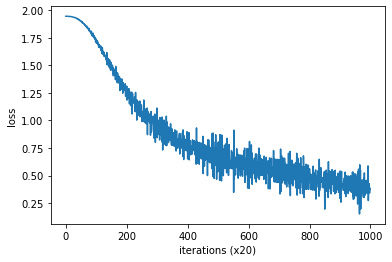

In [16]:
trainer.fit(contexts_oh, target_oh, max_epoch, batch_size)
trainer.plot()

가중치 매개변수 확인(단어별 밀집벡터)

In [17]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.0804338  0.8476362 -1.7535986  0.8582368  0.8847953]
say [-0.14005315 -1.2236539   0.3836958  -1.1913103  -1.2141836 ]
goodbye [1.0187483 1.0598229 0.2168692 1.0973785 1.0235796]
and [ 1.8255476  -0.969751    1.4715916  -0.94204336 -0.9535111 ]
i [1.0125648  1.0542954  0.24027362 1.0920773  0.9952637 ]
hello [ 1.0866468  0.8360564 -1.7604041  0.8402158  0.9084456]
. [-1.3691341 -1.1411885 -1.4993207 -1.1143558 -1.1164752]
